In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import scipy
import statsmodels.api as sm  #QQ plot

figure_kwargs = {
    'figsize': (6, 6),
    'dpi':100
}
plt.rcParams['figure.dpi'] = 100


## Reading and transforming data

In [2]:
data = pd.read_excel('Timeguessr_leaderboards_2.xlsx') 
data.to_csv('timeguessr.csv')
#data = pd.read_csv('timeguessr.csv', index_col=0)
# one column did not have a date, impute with guess
date_string = '2024-08-03 00:00:00'
data = data.rename(columns={'Unnamed: 36':  datetime.strptime(date_string, "%Y-%m-%d %H:%M:%S")})


In [3]:
columns = []
min_samples_to_keep = 0
for i in data.columns:
    if data[i].isna().sum()+min_samples_to_keep<len(data[i]): # skip days with to few observations
        columns.append(i)

In [4]:
new_format_date = datetime.strptime('2024-07-19 00:00:00', "%Y-%m-%d %H:%M:%S") # format changed after this date
for c in columns[1:]:
    if c > new_format_date:
        data[c] = data[c]*1_000

In [5]:
data = data[columns]
dataT = data.T
dataT.columns = dataT.iloc[0]
dataT.drop('Deltaker', inplace=True)
dates = [i.strftime('%m/%d') for i in dataT.T.columns] # make date format more readable

In [6]:
dataT.index = dates
dataT.values[dataT.values>50_000] = dataT.values[dataT.values>50_000]/1_000 # some inconsistent formating

In [7]:
# Nichoals misunderstood the game. Uncomment to add this correction to the analysis

#dataT['Nicholas'].iloc[0] = np.NaN
#dataT['Nicholas'].iloc[1] = np.NaN


In [8]:
values = dataT.values.astype(float)
values /=50_000 # normalizing with theoretical maximum for simplicity

In [9]:
print(values[~np.isnan(values)].mean())
print(values[~np.isnan(values)].std())

0.7202253571428571
0.11833213378278419


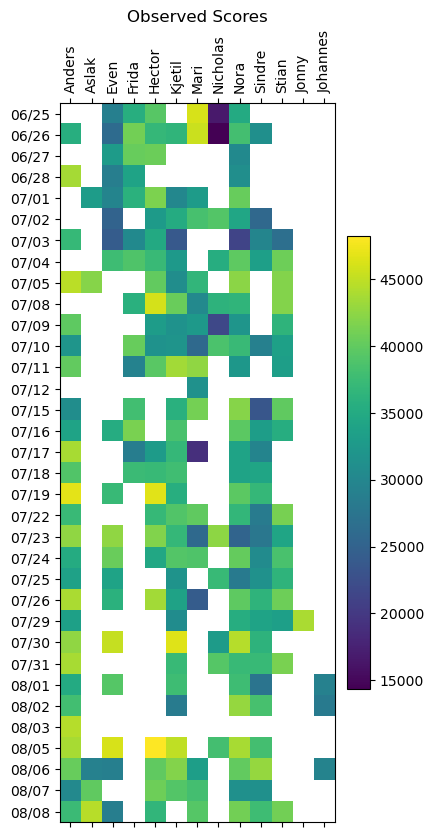

In [10]:
plt.matshow(values*50_000)
plt.title('Observed Scores')
plt.xticks(np.arange(0,len(dataT.columns)), dataT.columns, rotation=90)
plt.yticks(np.arange(0,len(dataT.index)), dataT.index)
plt.colorbar(fraction=0.073, pad=0.04)
plt.show()

## Defining models and performing Markov Chain Monte Carlo

In [11]:
rng = np.random.default_rng(seed=2024)

N, P = values.shape             # dimension of matrix
y = values                      # observed scores
n = np.nansum(y*0 + 1, axis=0)  # number of observation by player
p = np.nansum(y*0 + 1, axis=1)  # number of observations by day

mean_skill = np.array([0.5])    # mean of skill level
var_skill = np.array([0.1])     # variance of skill level
mu_sigma = np.array([0.1])      # mean of difficulty
var_sigma = np.array([0.1])     # variance of difficulty
var_y = np.array([0.5])         # variance of test outcom

skill = np.ones((1, len(dataT.columns)))*mean_skill[0]  # skill levels
sigma = np.ones((len(dataT.index), 1))*mu_sigma[0]      # difficulties

# hyper prior parameters means
prior_mean_skill = 0.1          # prior mean of skill level
prior_var_skill = 0.5           # prior variance of skill level
prior_mean_sigma = 0.75         # prior mean of difficulty
prior_var_sigma = 0.1           # prior variance of difficultt

# hyperprior parameters vars
prior_mean_skill = 0.1
alpha_skill = 1.01
beta_skill = prior_mean_skill*(alpha_skill-1)

prior_mean_sigma = 0.01
alpha_sigma = 10.01
beta_sigma = prior_mean_sigma*(alpha_sigma - 1)

prior_mean_y = 0.1
alpha_y = 1.01
beta_y = prior_mean_y*(alpha_y-1)

# saving traces
theta_trace = []
sigma_trace = []
var_y_trace = []

# Gibbs sampler
n_samples = 10_000
burn_in = 0.2
for i in range(n_samples):
    # skill | ...
    var_skill_prime = 1/(1/var_skill + n/var_y)
    mean_skill_prime = var_skill_prime*(mean_skill/var_skill \
                                        + (np.nansum(y - sigma, axis=0))/var_y)
    skill = rng.normal(mean_skill_prime, var_skill_prime)

    # mean_skill | ...
    prior_var_skill_prime = 1/(1/prior_var_skill + n/var_skill)
    prior_mean_skill_prime = prior_var_skill_prime*(prior_mean_skill/prior_mean_sigma + skill.sum()/var_skill)
    mean_skill = rng.normal(prior_mean_skill_prime, prior_var_skill_prime)

    # var_skill | ...
    alpha_skill_prime = alpha_skill + n/2
    beta_skill_prime = beta_skill + 0.5 * ((skill - mean_skill)**2).sum()
    var_skill = 1/rng.gamma(alpha_skill_prime, 1/beta_skill_prime)
    
    # sigma | ...
    var_sigma_prime = 1/(1/var_sigma + p/var_y)
    mean_sigma_prime = var_sigma_prime*(mu_sigma/var_sigma + (np.nansum(skill - y, axis=1))/var_y)
    sigma = rng.normal(mean_sigma_prime, var_sigma_prime).reshape([N, 1])

    # mean_sigma | ...
    prior_var_sigma_prime = 1/(1/prior_var_sigma + p/var_sigma)
    prior_mean_sigma_prime = prior_var_sigma_prime*(prior_mean_sigma/prior_mean_sigma \
                                                    + skill.sum()/var_sigma)
    mean_sigma = rng.normal(prior_mean_sigma_prime, prior_var_sigma_prime)

    # var_sigma | ...
    alpha_sigma_prime = alpha_sigma + p/2
    beta_sigma_prime = beta_sigma + 0.5 * ((sigma - mean_sigma)**2).sum()
    var_sigma = 1/rng.gamma(alpha_sigma_prime, 1/beta_sigma_prime)

    # var_y | ...
    alpha_y_prime = alpha_y + np.nansum(y*0 +1)/2
    mean_y = (skill[:, np.newaxis] - sigma.flatten()[np.newaxis, :]).T[::-1]
    beta_y_prime = beta_y + 0.5 * np.nansum(((y - mean_y)**2))
    var_y = 1/rng.gamma(alpha_y_prime, 1/beta_y_prime)

    # saving results
    theta_trace.append(skill)
    sigma_trace.append(sigma.T[0])
    var_y_trace.append(var_y)

theta_trace = np.array(theta_trace)[int(burn_in*len(theta_trace)):]
sigma_trace = np.array(sigma_trace)[int(burn_in*len(sigma_trace)):]
var_y_trace = np.array(var_y_trace)[int(burn_in*len(var_y_trace)):]

## Markov chain inspection 

In [12]:
# calculate posterior means for skill and difficulty
skill_hat = theta_trace.mean(axis=0)
indexes = np.argsort(-skill_hat)
sigma_hat = sigma_trace.mean(axis=0)
row_indexes = np.argsort(-sigma_hat.flatten())

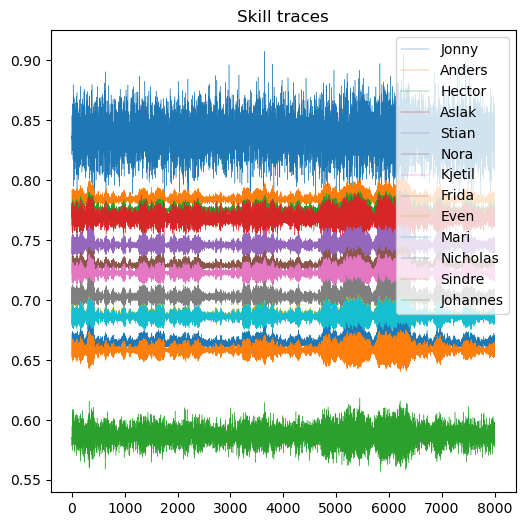

In [13]:
plt.figure(**figure_kwargs)
for i in indexes:
    plt.plot(theta_trace[:, i], label=dataT.columns[i], linewidth=0.3)
plt.title('Skill traces')
plt.legend()
plt.show()

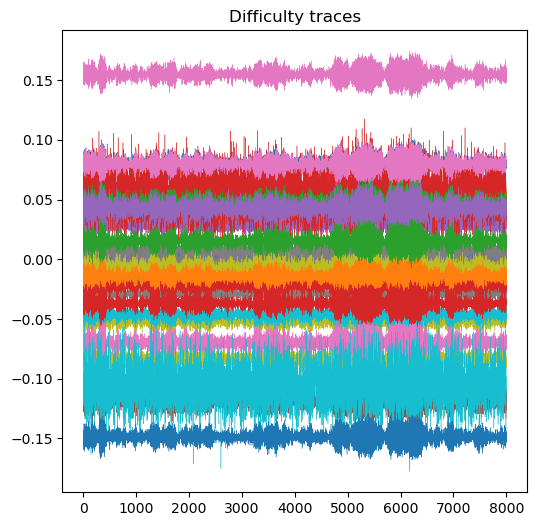

In [14]:
plt.figure(**figure_kwargs)
for i in range(N):
    plt.plot(sigma_trace[:, i], linewidth=0.3)
plt.title('Difficulty traces')
plt.show()

## Posterior distribution inference

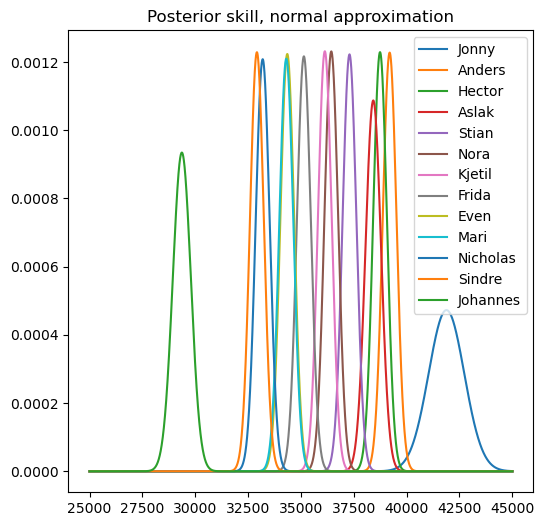

In [15]:
# Normal approximation
x_plot = np.linspace(25_000, 45_000, 10_000)
plt.figure(**figure_kwargs)
for i in indexes:
    trace = theta_trace[:, i]*50_000
    normal_appox = scipy.stats.norm(trace.mean(), trace.std())
    plt.plot(x_plot, normal_appox.pdf(x_plot), label=dataT.columns[i])
plt.title('Posterior skill, normal approximation')
plt.legend()
plt.show()

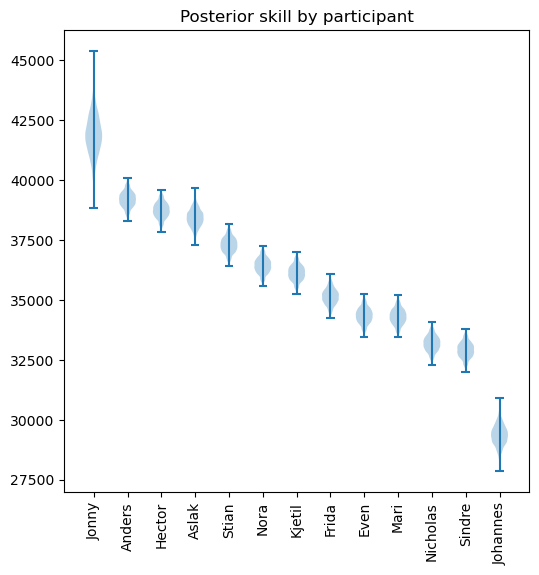

In [16]:
# Boxplots
plt.figure(**figure_kwargs)
theta_trace_sorted = np.zeros_like(theta_trace)
for i in range(len(indexes)):
    theta_trace_sorted[:, i] = theta_trace[:, indexes[i]] 
theta_trace_sorted*=50_000
plt.violinplot(theta_trace_sorted)
plt.xticks(np.arange(1,len(dataT.columns)+1), dataT.columns[indexes], rotation=90)
plt.title('Posterior skill by participant')
plt.show()

In [17]:
# Sort rows by difficulty
sigma_trace_sorted = np.zeros_like(sigma_trace)
for i in range(len(row_indexes)):
    sigma_trace_sorted[:, i] = sigma_trace[:, row_indexes[i]] 

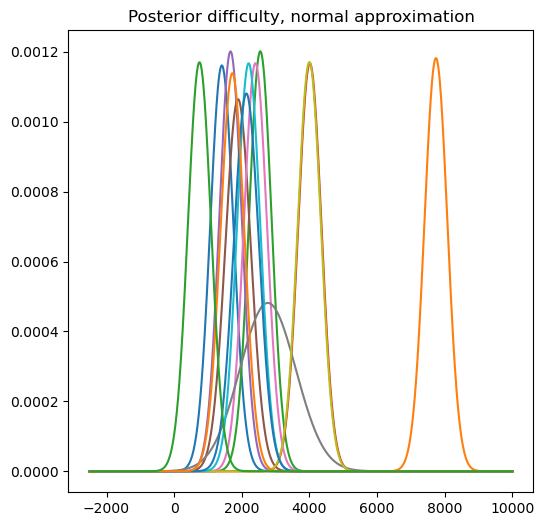

In [18]:
# Normal approximation
x_plot = np.linspace(-2_500, 10_000, 1000)
plt.figure(**figure_kwargs)
for i in indexes:
    trace = sigma_trace_sorted[:, i]*50_000
    normal_appox = scipy.stats.norm(trace.mean(), trace.std())
    plt.plot(x_plot, normal_appox.pdf(x_plot))
plt.title('Posterior difficulty, normal approximation')
plt.show()

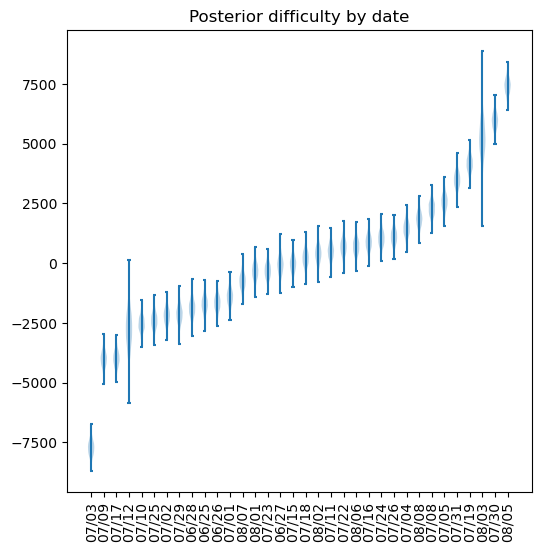

In [19]:
plt.figure(**figure_kwargs)
plt.violinplot(-sigma_trace_sorted*50_000)
plt.xticks(np.arange(1,len(dataT.index)+1), dataT.index[row_indexes], rotation=90)
plt.title('Posterior difficulty by date')
plt.show()

## Posterior score estimates and comparison

In [20]:
estimated_scores = (skill_hat[:, np.newaxis] - sigma_hat.flatten()[np.newaxis, :]).T[::-1]
estimates = pd.DataFrame((estimated_scores*50_000).astype(int), columns=dataT.columns)

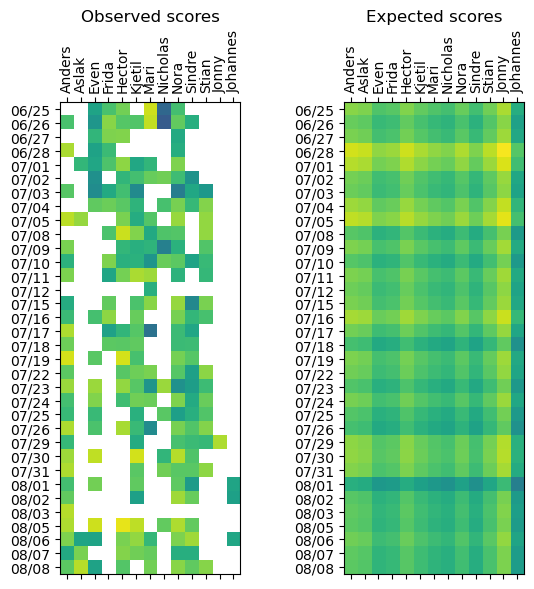

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, **figure_kwargs)

cax1 = ax1.matshow(values)
cax2 = ax2.matshow(estimated_scores)
ax1.set_yticks(np.arange(0,len(dataT.index)), dataT.index)
ax2.set_yticks(np.arange(0,len(dataT.index)), dataT.index)
ax1.set_xticks(np.arange(0,len(dataT.columns)), dataT.columns, rotation=90, )
ax2.set_xticks(np.arange(0,len(dataT.columns)), dataT.columns, rotation=90, )
cax1.set_clim(0,1)
cax2.set_clim(0,1)
ax1.set_title('Observed scores')
ax2.set_title('Expected scores')

plt.tight_layout()
plt.show()

In [22]:
dataT.loc['07/29']

Deltaker
Anders      33571.0
Aslak           NaN
Even            NaN
Frida           NaN
Hector          NaN
Kjetil      30811.0
Mari            NaN
Nicholas        NaN
Nora        35392.0
Sindre      34007.0
Stian       33423.0
Jonny       43859.0
Johannes        NaN
Name: 07/29, dtype: object

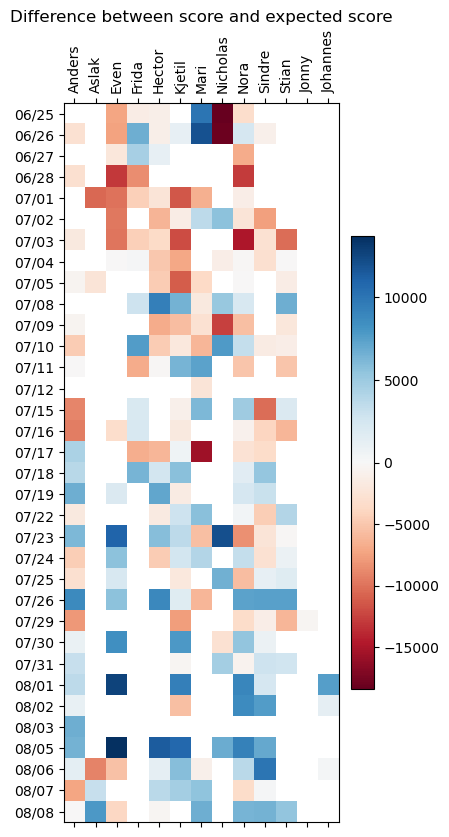

In [23]:
z = ((values-estimated_scores))*50_000
from matplotlib.colors import TwoSlopeNorm
norm = TwoSlopeNorm(vmin=np.nanmin(z), vcenter=0, vmax=np.nanmax(z))
plt.matshow(z, cmap='RdBu', norm=norm)
plt.colorbar(fraction=0.073, pad=0.04)
plt.yticks(np.arange(0,len(dataT.index)), dataT.index)
plt.xticks(np.arange(0,len(dataT.columns)), dataT.columns, rotation=90, )
plt.title('Difference between score and expected score')
plt.show()

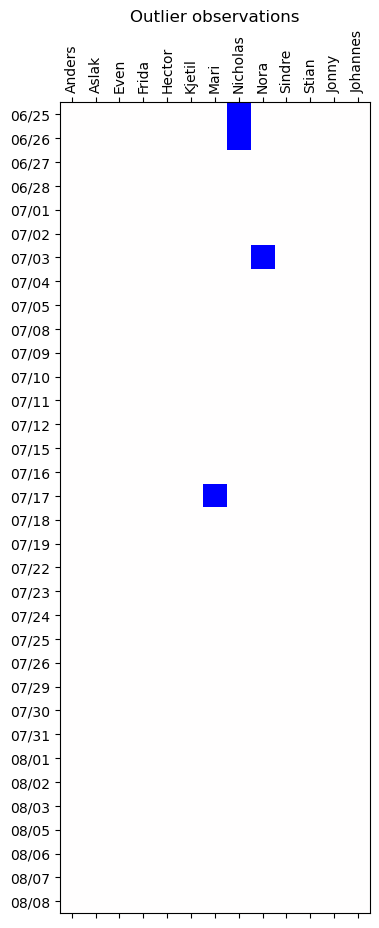

In [24]:
outliers = scipy.stats.norm(estimated_scores, np.sqrt(var_y_trace.mean())).cdf(values)
plt.matshow(-(outliers < 0.01).astype(int) + (outliers>0.99).astype(int), cmap='bwr')
plt.clim(-1,1)
plt.yticks(np.arange(0,len(dataT.index)), dataT.index)
plt.xticks(np.arange(0,len(dataT.columns)), dataT.columns, rotation=90, )
plt.title('Outlier observations')
plt.show()

In [25]:
data_sorted = dataT.copy()
data_sorted = data_sorted.iloc[row_indexes]
data_sorted = data_sorted[data_sorted.columns[indexes]]

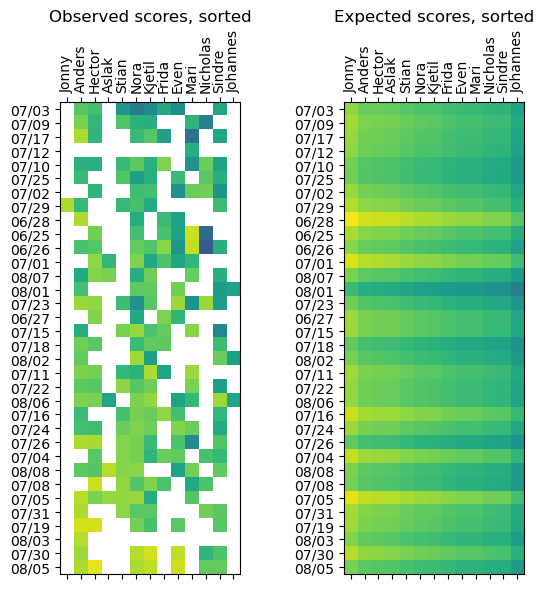

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, **figure_kwargs)

estimates = estimates.iloc[row_indexes]
estimates = estimates[estimates.columns[indexes]]

cax1 = ax1.matshow(data_sorted.values.astype(float)/50_000)
cax2 = ax2.matshow(estimates/50_000)
ax1.set_yticks(np.arange(0,len(data_sorted.index)), data_sorted.index)
ax1.set_xticks(np.arange(0,len(data_sorted.columns)), data_sorted.columns, rotation=90, )
ax2.set_yticks(np.arange(0,len(data_sorted.index)), data_sorted.index)
ax2.set_xticks(np.arange(0,len(data_sorted.columns)), data_sorted.columns, rotation=90, )
cax1.set_clim(0,1)
cax2.set_clim(0,1)
ax1.set_title('Observed scores, sorted')
ax2.set_title('Expected scores, sorted')

plt.tight_layout()
plt.show()

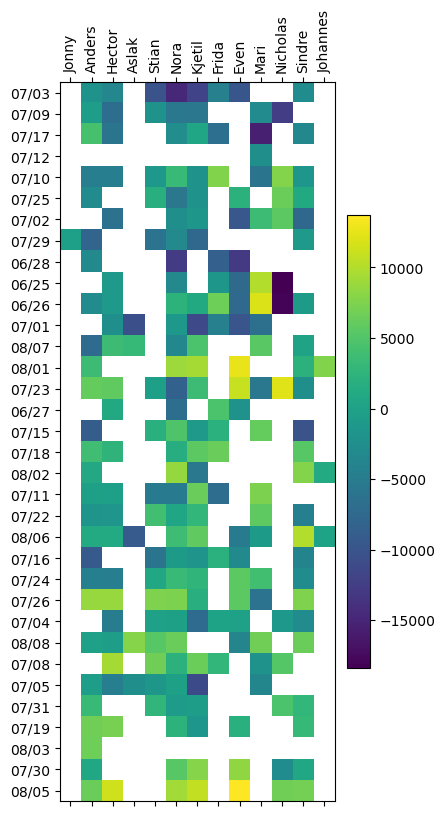

In [27]:
plt.matshow(((data_sorted.values.astype(float)-estimates.values)))
#plt.clim(0,50_000)
plt.yticks(np.arange(0,len(data_sorted.index)), data_sorted.index)
plt.xticks(np.arange(0,len(data_sorted.columns)), data_sorted.columns, rotation=90)
plt.colorbar(fraction=0.073, pad=0.04)
plt.title('')
plt.show()

## Some model diagnostics

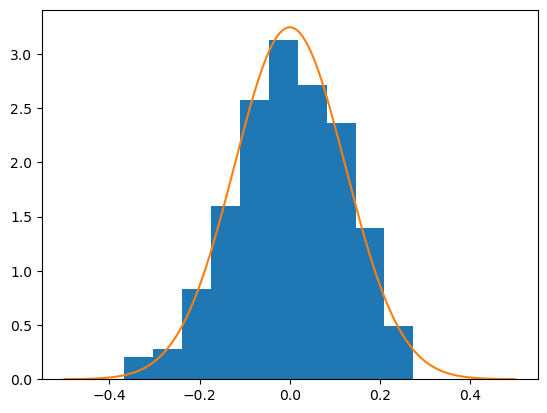

In [28]:
z = (data_sorted.values.astype(float)-estimates.values)/50_000
z = z[~np.isnan(z)]
xplot = np.linspace(-0.5,0.5,1_000)
plt.hist(z[~np.isnan(z)], density=True)
plt.plot(xplot, scipy.stats.norm(0, np.sqrt(var_y_trace.mean())).pdf(xplot))


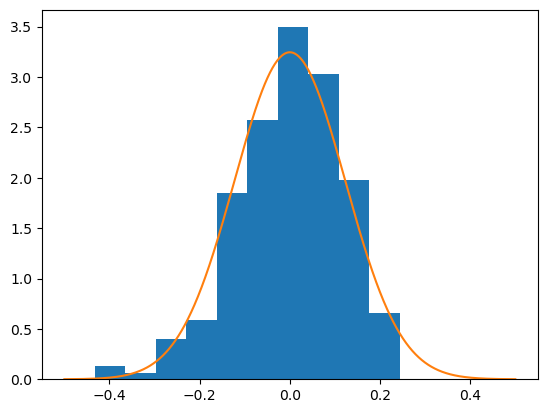

In [29]:
xplot = np.linspace(-0.5,0.5,1_000)
z = (data_sorted.values.astype(float))/50_000
z-=np.nanmean(z)
plt.hist(z[~np.isnan(z)], density=True)
plt.plot(xplot, scipy.stats.norm(0, np.sqrt(var_y_trace.mean())).pdf(xplot))

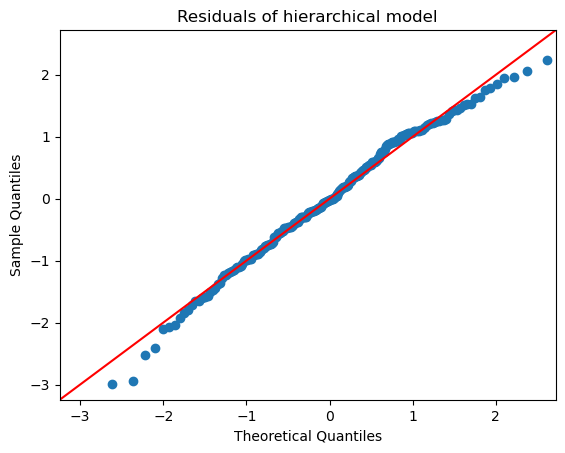

In [30]:
z = (data_sorted.values.astype(float)-estimates.values)/50_000
z = z[~np.isnan(z)]
z -= z.mean()
z /= np.sqrt(var_y_trace.mean())
sm.qqplot(z, line ='45')
plt.title('Residuals of hierarchical model')
plt.show()

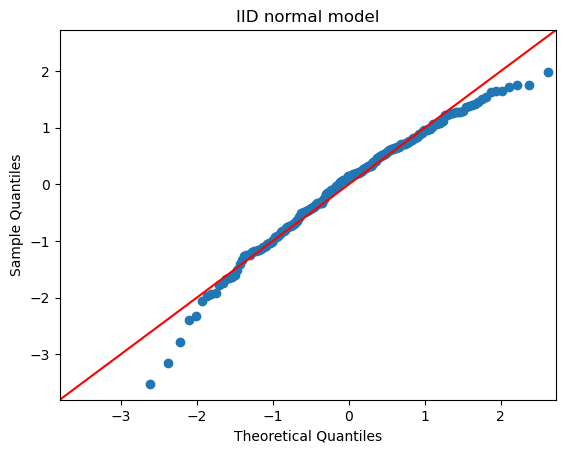

In [31]:
z = (data_sorted.values.astype(float))/50_000
z = z[~np.isnan(z)]
z -= z.mean()
z /= np.sqrt(var_y_trace.mean())
sm.qqplot(z, line ='45')
plt.title('IID normal model')
plt.show()

In [32]:
for i, name in enumerate(dataT.columns):
    print(name, np.nanmean(dataT.values, axis=1)[i])

means = np.nanmean(dataT.values, axis=1)

Anders 33638.666666666664
Aslak 33933.88888888889
Even 36095.25
Frida 34395.5
Hector 34811.42857142857
Kjetil 32951.57142857143
Mari 28528.5
Nicholas 36972.875
Nora 39799.28571428572
Sindre 38188.42857142857
Stian 32459.714285714286
Jonny 33382.11111111111
Johannes 37250.57142857143


In [33]:

for i in indexes:
    name = dataT.columns[i]
    print(name, 50_000*np.nanmean(estimated_scores, axis=1)[i])

Jonny 33547.91248030163
Anders 37803.65521056243
Hector 41173.94313374155
Aslak 35201.75180886284
Stian 37056.82277081497
Nora 41926.07414741269
Kjetil 36336.99377151488
Frida 43383.007776893326
Even 36649.97782829809
Mari 35612.862963843974
Nicholas 39438.3126777317
Sindre 33815.51917809673
Johannes 36985.44647283573


In [34]:
z = ((values-estimated_scores))


In [35]:
list(zip(dataT.columns, np.nanmean(z, axis=0)*50_000))

[('Anders', -117.91811056282204),
 ('Aslak', -2202.7745285270116),
 ('Even', -548.6977684655769),
 ('Frida', 19.74864005553594),
 ('Hector', 119.18558977349905),
 ('Kjetil', -28.130941302264922),
 ('Mari', 493.19298930775415),
 ('Nicholas', -373.7937611077824),
 ('Nora', -223.77062819203783),
 ('Sindre', 423.0097219665295),
 ('Stian', -96.78337668195194),
 ('Jonny', -317.7557645996865),
 ('Johannes', 2997.828204754825)]

## Does skill increase over time?

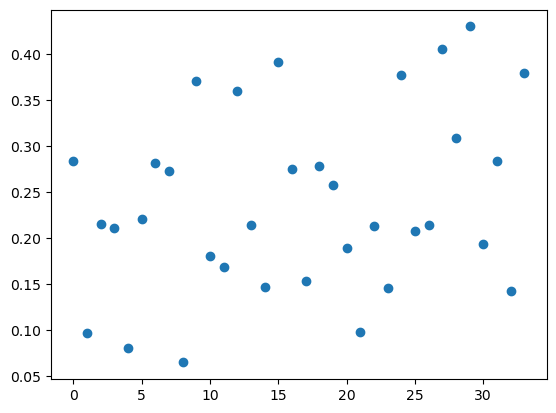

In [36]:
plt.scatter(range(len(mean_sigma)), mean_sigma)

In [37]:
from scipy.stats import linregress

linregress(np.arange(0,len(mean_sigma)), mean_sigma)

LinregressResult(slope=0.0028126150735475254, intercept=0.19243990769677582, rvalue=0.28498558530012963, pvalue=0.10233028859725328, stderr=0.0016723183052435738, intercept_stderr=0.03210241388787507)

Yes! But not significantly. A more sophisticated analysis might shed more light